# Selcción de modelos

- [Importar librerías](#Importar-librerías)
- [Lectura de los datasets](#Lectura-de-los-datasets)
- [Pruebas con distintos modelos](#Pruebas-con-distintos-modelos)
- [Estudio de pesos con características](#Estudio-de-pesos-con-características)
- [Optimización de modelos](#Optimización-de-modelos)
- [Adicional: entrenamiento de red neuronal](#Adicional:-entrenamiento-de-red-neuronal)
- [Exportar modelos](#Exportar-modelos)
- [Submission](#Submission)

## Importar librerías

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.stats as stats
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.base import BaseEstimator, ClassifierMixin

## Lectura de los datasets

In [3]:
df_train = pd.read_csv("./00_Data/Cleaned/train_clean.csv")
print("Train dimensions:", df_train.shape)

Train dimensions: (891, 9)


### Partición train / test
En la competición oficial evaluarían directamente nuestras predicciones sobre df_test, pero en local no tenemos modo de validarlo, por lo que tendremos que hacer la partición train-test para evaluar (supondremos que el de validación es el final de la competición).

In [4]:
# Separar las características (X) y la variable objetivo (y)
X = df_train.drop('Survived', axis=1)
y = df_train['Survived']

# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

## Pruebas con distintos modelos

Nos centraremos principalmente en la 'Accuracy', pues es la métrica de la competición, aunque miraremos las principales de clasificación.

In [5]:
# Función para calcular métricas tras la predicción
def classification_metrics(y_test, y_pred, name, model=np.NaN, roc_bool=True):
    """
    Calcula y muestra diversas métricas de clasificación tras realizar una predicción.

    Parámetros:
    -----------
    y_test : array-like
        Valores verdaderos de la variable objetivo (labels) del conjunto de test.
    y_pred : array-like
        Valores predichos por el modelo.
    name : str
        Nombre o descripción del modelo, utilizado para etiquetar la salida.
    model : object, optional
        Modelo utilizado para hacer la predicción. Se utiliza para calcular la métrica
        ROC-AUC si el modelo soporta la función `predict_proba()`. Por defecto, es np.NaN.
    roc_bool : bool, optional
        Variable para pintar (o no) la curva ROC-AUC.

    Métricas calculadas:
    --------------------
    - Accuracy: Precisión del modelo.
    - Matriz de confusión: Representación de los aciertos y errores del modelo.
    - Reporte de clasificación: Incluye precisión, recall, F1-score, etc.
    - ROC-AUC: Se calcula solo si el modelo soporta `predict_proba()`.
    
    Devuelve:
    ---------
    data_metrics : pd.DataFrame
        Dataframe con la información de métricas del modelo evaluado en la función.
    """
    
    # Calcular la precisión (accuracy)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Mostrar resultados
    print(f"\n----- {name} -----")
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    metrics_summary = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-Score': [], 'ROC-AUC': []}

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Calcular y mostrar ROC-AUC si el modelo lo permite y se pide
    if roc_bool:
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:,1]
            roc_auc = roc_auc_score(y_test, y_proba)
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            print(f"ROC-AUC: {roc_auc:.4f}")
            
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')
            plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
            plt.xlabel('Tasa de Falsos Positivos')
            plt.ylabel('Tasa de Verdaderos Positivos')
            plt.title('Curva ROC')
            plt.legend()
            plt.show()
        
        else:
            print(f"ROC-AUC: No disponible para {name}")

     # Almacenar los resultados en el diccionario
    metrics_summary['Model'].append(name)
    metrics_summary['Accuracy'].append(accuracy)
    metrics_summary['Precision'].append(precision)
    metrics_summary['Recall'].append(recall)
    metrics_summary['F1-Score'].append(f1)
    if roc_bool == True & hasattr(model, "predict_proba"):
        metrics_summary['ROC-AUC'].append(roc_auc)
    else:
        metrics_summary['ROC-AUC'].append(np.NaN)
    
    return pd.DataFrame(metrics_summary)

# Función para entrenar y evaluar modelos
def evaluate_models(models, X_train, X_test, y_train, y_test):
    """
    Entrena y evalúa múltiples modelos de clasificación en un conjunto de datos de prueba.

    Parámetros:
    -----------
    models : dict
        Un diccionario donde las claves son los nombres de los modelos (como cadenas de texto) 
        y los valores son instancias de los modelos de clasificación.
    X_train : array-like
        Características (features) del conjunto de entrenamiento.
    X_test : array-like
        Características (features) del conjunto de prueba.
    y_train : array-like
        Valores verdaderos de la variable objetivo (labels) del conjunto de entrenamiento.
    y_test : array-like
        Valores verdaderos de la variable objetivo (labels) del conjunto de prueba.

    Funcionalidad:
    --------------
    - Entrena cada modelo en `models` usando el conjunto de entrenamiento `X_train` y `y_train`.
    - Predice los valores de la variable objetivo en `X_test` para cada modelo.
    - Calcula y muestra métricas de clasificación (incluyendo accuracy, matriz de confusión, 
      reporte de clasificación y ROC-AUC si está disponible) utilizando la función 
      `classification_metrics`.

    Devuelve:
    ---------
    data_metrics : pd.DataFrame
        Dataframe con la información de métricas de cada modelo evaluado en la función.
    """

    data_metrics = pd.DataFrame()
    
    # Iterar sobre todos los modelos definidos
    for name, model in models.items():
       
        # Entrenar el modelo
        model.fit(X_train, y_train)
        
        # Predecir en los datos de prueba
        y_pred = model.predict(X_test)

        # Sacar métricas
        df_met_model = classification_metrics(y_test, y_pred, name, model)

        # Métricas training
        print("--- MÉTRICAS CON ENTRENAMIENTO: ---")
        df_met_model_train = classification_metrics(y_train, model.predict(X_train), name, model, roc_bool=False)

        # Renombrar columnas de df_met_model_train para concatenar
        df_met_model_train = df_met_model_train.drop(columns=["ROC-AUC"])
        df_met_model_train.rename(columns={col: col + '_train' for col in df_met_model_train.columns if col != 'Model'}, inplace=True)
        
        # Juntar los dos dataframes en uno
        df_met_model = df_met_model.merge(df_met_model_train, left_on='Model', right_on='Model')
        
        if data_metrics.shape[0] > 0:
            data_metrics = pd.concat([data_metrics, df_met_model])
        else:
            data_metrics = df_met_model

    return data_metrics.reset_index(drop=True).loc[:, ['Model', 'Accuracy_train', 'Accuracy', 'Precision_train', 'Precision', 'Recall_train', 'Recall', 'F1-Score_train', 'F1-Score', 'ROC-AUC']]

In [6]:
# Defir nuestros benchmarks (modelos que predicen siempre 1 o siempre 0)

# Quito los warnings para estas métricas
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Predicción de 0 siempre
_ = classification_metrics(y_test, np.zeros(len(y_test), dtype='int64'), "Dummy_0")

# Predicción de 1 siempre
_ = classification_metrics(y_test, np.ones(len(y_test), dtype='int64'), "Dummy_1")


----- Dummy_0 -----
Accuracy: 0.6145
Confusion Matrix:
[[110   0]
 [ 69   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.61      1.00      0.76       110
           1       0.00      0.00      0.00        69

    accuracy                           0.61       179
   macro avg       0.31      0.50      0.38       179
weighted avg       0.38      0.61      0.47       179

ROC-AUC: No disponible para Dummy_0

----- Dummy_1 -----
Accuracy: 0.3855
Confusion Matrix:
[[  0 110]
 [  0  69]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       110
           1       0.39      1.00      0.56        69

    accuracy                           0.39       179
   macro avg       0.19      0.50      0.28       179
weighted avg       0.15      0.39      0.21       179

ROC-AUC: No disponible para Dummy_1



----- Logistic Regression -----
Accuracy: 0.7989
Confusion Matrix:
[[96 14]
 [22 47]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       110
           1       0.77      0.68      0.72        69

    accuracy                           0.80       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.80      0.80      0.80       179

ROC-AUC: 0.8371


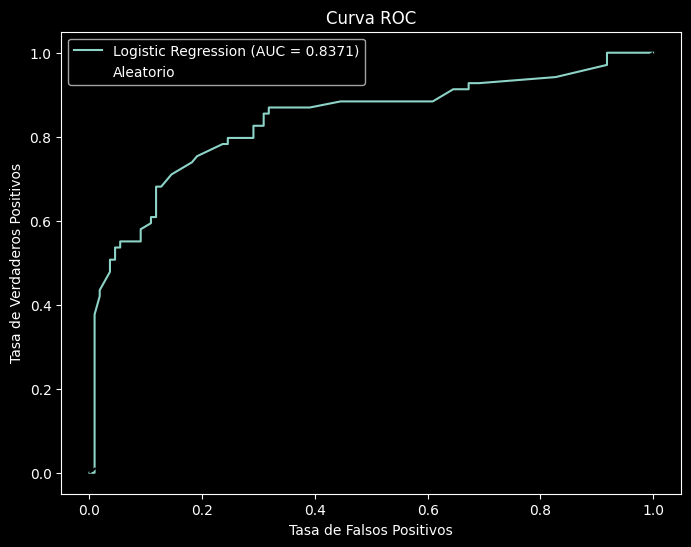

--- MÉTRICAS CON ENTRENAMIENTO: ---

----- Logistic Regression -----
Accuracy: 0.8104
Confusion Matrix:
[[380  59]
 [ 76 197]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       439
           1       0.77      0.72      0.74       273

    accuracy                           0.81       712
   macro avg       0.80      0.79      0.80       712
weighted avg       0.81      0.81      0.81       712


----- Decision Tree -----
Accuracy: 0.7989
Confusion Matrix:
[[98 12]
 [24 45]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       110
           1       0.79      0.65      0.71        69

    accuracy                           0.80       179
   macro avg       0.80      0.77      0.78       179
weighted avg       0.80      0.80      0.79       179

ROC-AUC: 0.8335


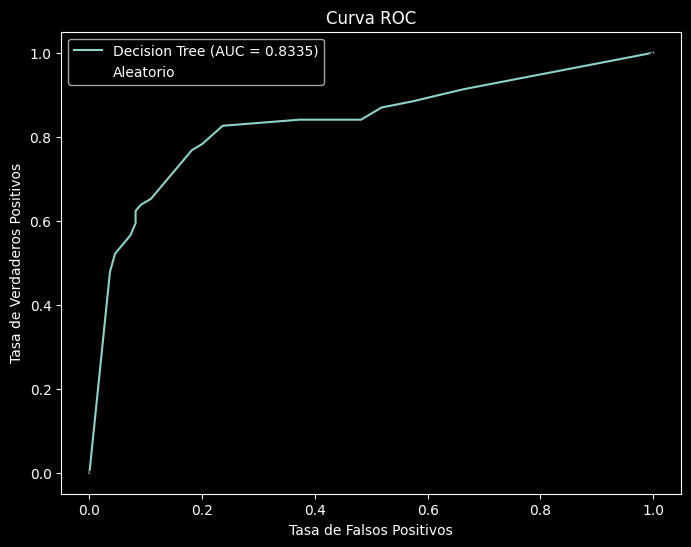

--- MÉTRICAS CON ENTRENAMIENTO: ---

----- Decision Tree -----
Accuracy: 0.8890
Confusion Matrix:
[[419  20]
 [ 59 214]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       439
           1       0.91      0.78      0.84       273

    accuracy                           0.89       712
   macro avg       0.90      0.87      0.88       712
weighted avg       0.89      0.89      0.89       712


----- Random Forest -----
Accuracy: 0.7989
Confusion Matrix:
[[97 13]
 [23 46]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       110
           1       0.78      0.67      0.72        69

    accuracy                           0.80       179
   macro avg       0.79      0.77      0.78       179
weighted avg       0.80      0.80      0.80       179

ROC-AUC: 0.8383


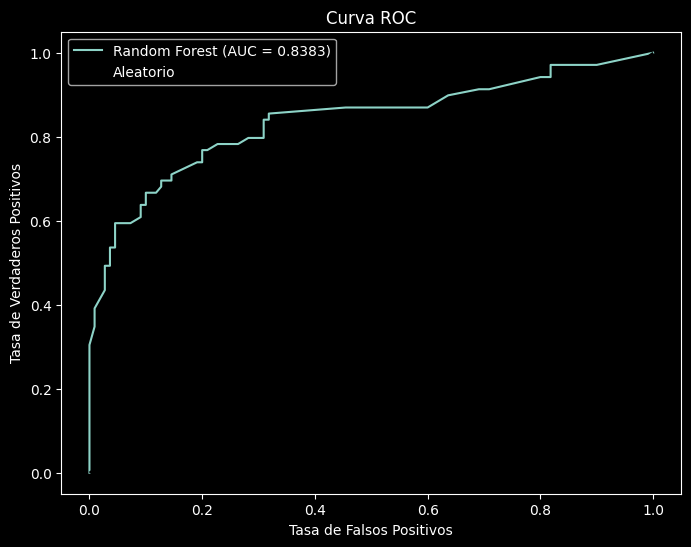

--- MÉTRICAS CON ENTRENAMIENTO: ---

----- Random Forest -----
Accuracy: 0.8890
Confusion Matrix:
[[414  25]
 [ 54 219]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       439
           1       0.90      0.80      0.85       273

    accuracy                           0.89       712
   macro avg       0.89      0.87      0.88       712
weighted avg       0.89      0.89      0.89       712


----- Linear SVM -----
Accuracy: 0.7765
Confusion Matrix:
[[94 16]
 [24 45]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       110
           1       0.74      0.65      0.69        69

    accuracy                           0.78       179
   macro avg       0.77      0.75      0.76       179
weighted avg       0.77      0.78      0.77       179

ROC-AUC: 0.8062


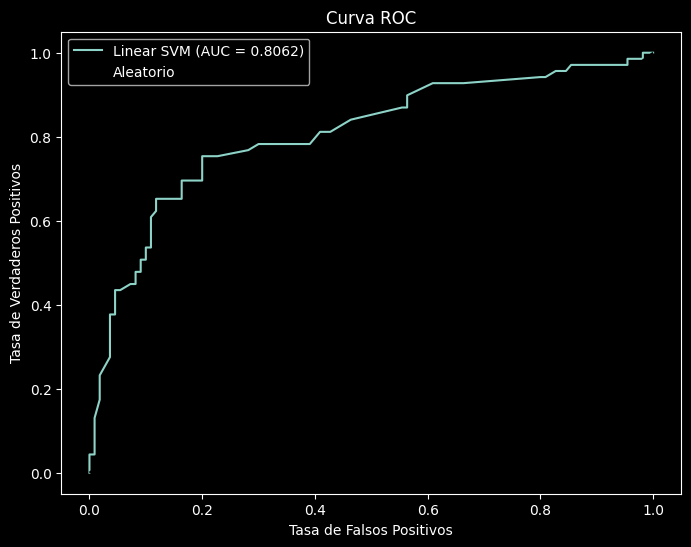

--- MÉTRICAS CON ENTRENAMIENTO: ---

----- Linear SVM -----
Accuracy: 0.7893
Confusion Matrix:
[[374  65]
 [ 85 188]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       439
           1       0.74      0.69      0.71       273

    accuracy                           0.79       712
   macro avg       0.78      0.77      0.77       712
weighted avg       0.79      0.79      0.79       712


----- SVM -----
Accuracy: 0.8324
Confusion Matrix:
[[99 11]
 [19 50]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       110
           1       0.82      0.72      0.77        69

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179

ROC-AUC: 0.8517


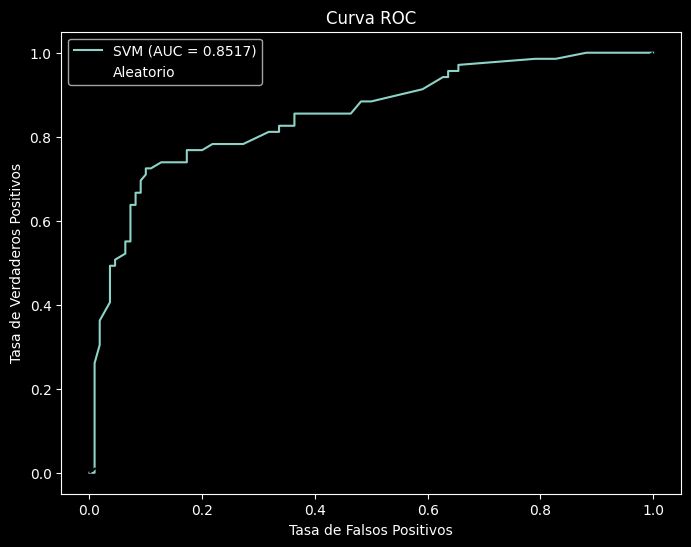

--- MÉTRICAS CON ENTRENAMIENTO: ---

----- SVM -----
Accuracy: 0.8329
Confusion Matrix:
[[394  45]
 [ 74 199]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       439
           1       0.82      0.73      0.77       273

    accuracy                           0.83       712
   macro avg       0.83      0.81      0.82       712
weighted avg       0.83      0.83      0.83       712



In [7]:
# Definir los modelos a probar
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Linear SVM': SVC(kernel='linear', probability=True),  # probability=True para poder obtener ROC-AUC
    'SVM': SVC(probability=True)  # probability=True para poder obtener ROC-AUC
}

# Evaluar modelos
metrics_summary = evaluate_models(models, X_train, X_test, y_train, y_test)

In [8]:
metrics_summary.reset_index(drop=True)

,Model,Accuracy_train,Accuracy,Precision_train,Precision,Recall_train,Recall,F1-Score_train,F1-Score,ROC-AUC
0,Logistic Regression,0.810393,0.798883,0.769531,0.770492,0.721612,0.681159,0.744802,0.723077,0.837088
1,Decision Tree,0.889045,0.798883,0.914530,0.789474,0.783883,0.652174,0.844181,0.714286,0.833465
2,Random Forest,0.889045,0.798883,0.897541,0.779661,0.802198,0.666667,0.847195,0.718750,0.838274
3,Linear SVM,0.789326,0.776536,0.743083,0.737705,0.688645,0.652174,0.714829,0.692308,0.806192
4,SVM,0.832865,0.832402,0.815574,0.819672,0.728938,0.724638,0.769826,0.769231,0.851713


Comprobamos que el modelo que mejor comportamiento tiene es el Random Forest, aunque SVM (no linear) se comporta bastante bien también. Resaltar que hay que tener cuidado, puesto que parece que en los modelos de árboles la precisión es considerablemente mayor en training que en test.

## Estudio de pesos de características

### Regresión logística

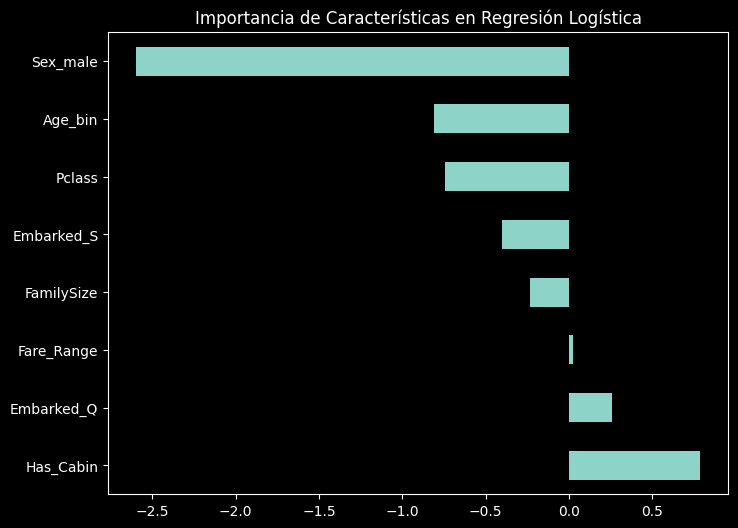

In [9]:
logreg = models["Logistic Regression"]

# Obtener los coeficientes del modelo
feature_importance = pd.Series(logreg.coef_[0], index=X.columns)

# Ordenar las características por importancia
feature_importance = feature_importance.sort_values(ascending=False)

# Graficar los coeficientes
plt.figure(figsize=(8, 6))
feature_importance.plot(kind='barh')
plt.title('Importancia de Características en Regresión Logística')
plt.show()

### Árboles de decisión

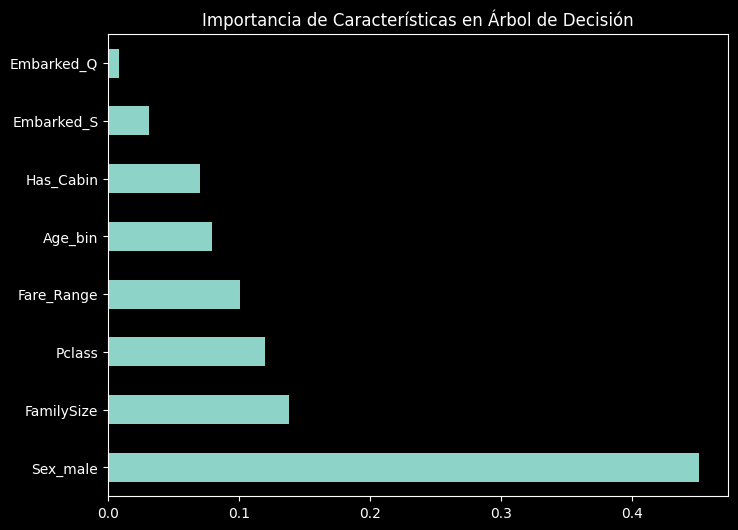

In [10]:
dt = models["Decision Tree"]

# Obtener las importancias de las características
feature_importance_dt = pd.Series(dt.feature_importances_, index=X.columns)

# Ordenar las características por importancia
feature_importance_dt = feature_importance_dt.sort_values(ascending=False)

# Graficar las importancias
plt.figure(figsize=(8, 6))
feature_importance_dt.plot(kind='barh')
plt.title('Importancia de Características en Árbol de Decisión')
plt.show()

### Random Forest

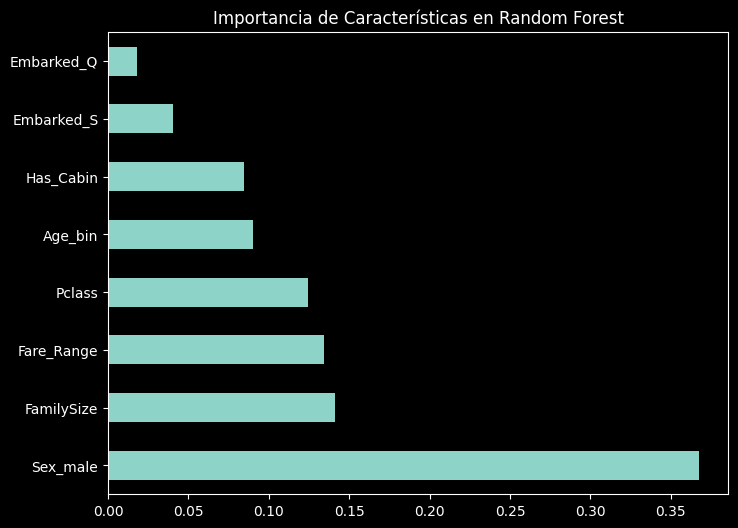

In [11]:
rf = models["Random Forest"]

# Obtener las importancias de las características
feature_importance_rf = pd.Series(rf.feature_importances_, index=X.columns)

# Ordenar las características por importancia
feature_importance_rf = feature_importance_rf.sort_values(ascending=False)

# Graficar las importancias
plt.figure(figsize=(8, 6))
feature_importance_rf.plot(kind='barh')
plt.title('Importancia de Características en Random Forest')
plt.show()

### SVM

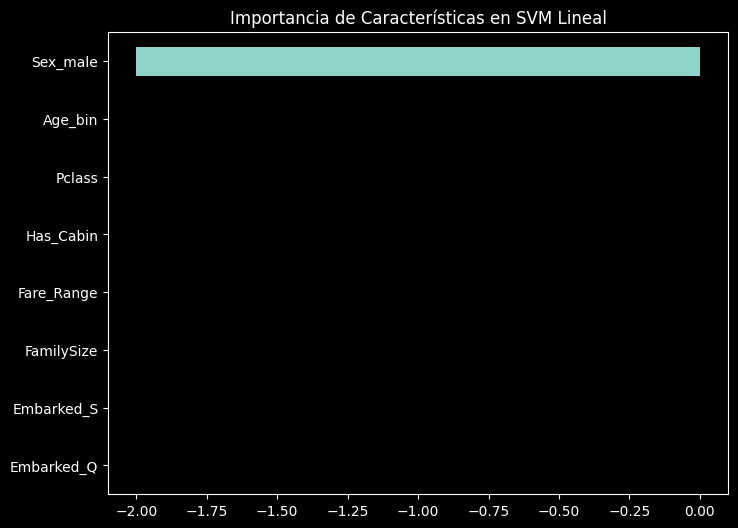

In [12]:
svm = models["Linear SVM"]

# Obtener los coeficientes del modelo
feature_importance_svm = pd.Series(svm.coef_[0], index=X.columns)

# Ordenar las características por importancia
feature_importance_svm = feature_importance_svm.sort_values(ascending=False)

# Graficar los coeficientes
plt.figure(figsize=(8, 6))
feature_importance_svm.plot(kind='barh')
plt.title('Importancia de Características en SVM Lineal')
plt.show()

### Conclusiones 
Parece que existen características con una importancia mucho mayor que otras (sexo principalmente), aunque todas tienen cierta relevancia en general, por lo que buscaremos optimizar algunos modelos de los seleccionados y ver si alcanzamos una precisión buena o volvemos a capturar nuevas características.

## Optimización de modelos

### Random Forest

In [13]:
# Definir hiperparámetros para ajustar un modelo de Random Forest
param_distributions_rf = {
    'n_estimators': [10, 50, 80, 100, 200, 300, 1000],
    'max_depth': [4, 6, 8],
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False],
    'criterion': ["gini", "entropy"]
}

# Aplicar RandomizedSearchCV
start_time = time.time()  # Iniciar el temporizador
random_search_rf = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_distributions_rf,
    n_iter=20,  # Número de combinaciones aleatorias que se probarán
    cv=5,  # Validación cruzada de 5 pliegues
    scoring='accuracy',
    verbose=3,
    random_state=42,  # Para reproducibilidad
    return_train_score=True  # Para obtener las puntuaciones en entrenamiento
)

random_search_rf.fit(X_train, y_train)

# Detener el temporizador y calcular el tiempo transcurrido
end_time = time.time()
elapsed_time = end_time - start_time
print(f"El tiempo total de ejecución fue: {elapsed_time:.2f} segundos")

# Mostrar los mejores parámetros y la mejor puntuación obtenida
print("\nMejores parámetros para Random Forest:")
print(random_search_rf.best_params_)
print(f"Mejor precisión en validación cruzada: {random_search_rf.best_score_:.4f}")

# Evaluar el modelo ajustado en el conjunto de prueba
best_rf = random_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print(f"Precisión del mejor Random Forest en el conjunto de prueba: {accuracy_score(y_test, y_pred_rf):.4f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END bootstrap=False, criterion=gini, max_depth=6, min_samples_split=10, n_estimators=200;, score=(train=0.872, test=0.811) total time=   0.1s
[CV 2/5] END bootstrap=False, criterion=gini, max_depth=6, min_samples_split=10, n_estimators=200;, score=(train=0.866, test=0.769) total time=   0.1s
[CV 3/5] END bootstrap=False, criterion=gini, max_depth=6, min_samples_split=10, n_estimators=200;, score=(train=0.867, test=0.831) total time=   0.1s
[CV 4/5] END bootstrap=False, criterion=gini, max_depth=6, min_samples_split=10, n_estimators=200;, score=(train=0.863, test=0.852) total time=   0.1s
[CV 5/5] END bootstrap=False, criterion=gini, max_depth=6, min_samples_split=10, n_estimators=200;, score=(train=0.861, test=0.810) total time=   0.1s
[CV 1/5] END bootstrap=True, criterion=gini, max_depth=4, min_samples_split=2, n_estimators=1000;, score=(train=0.845, test=0.818) total time=   0.4s
[CV 2/5] END bootstrap=True, crit

In [14]:
# Definir hiperparámetros para ajustar un modelo de Random Forest
param_grid_rf = {
    'n_estimators': [10, 50, 60, 80, 100, 150, 200, 500],
    'max_depth': [4, 5, 6, 7, 8],
    'min_samples_split': [4, 5, 6],
    'bootstrap': [False, True],
    'criterion': ["gini", "entropy"]
}

# Aplicar GridSearchCV
start_time = time.time()  # Iniciar el temporizador
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy', verbose=3, return_train_score=True)
grid_search_rf.fit(X_train, y_train)

# Detener el temporizador y calcular el tiempo transcurrido
end_time = time.time()
elapsed_time = end_time - start_time
print(f"El tiempo total de ejecución fue: {elapsed_time:.2f} segundos")

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
[CV 1/5] END bootstrap=False, criterion=gini, max_depth=4, min_samples_split=4, n_estimators=10;, score=(train=0.842, test=0.811) total time=   0.0s
[CV 2/5] END bootstrap=False, criterion=gini, max_depth=4, min_samples_split=4, n_estimators=10;, score=(train=0.845, test=0.776) total time=   0.0s
[CV 3/5] END bootstrap=False, criterion=gini, max_depth=4, min_samples_split=4, n_estimators=10;, score=(train=0.832, test=0.852) total time=   0.0s
[CV 4/5] END bootstrap=False, criterion=gini, max_depth=4, min_samples_split=4, n_estimators=10;, score=(train=0.828, test=0.859) total time=   0.0s
[CV 5/5] END bootstrap=False, criterion=gini, max_depth=4, min_samples_split=4, n_estimators=10;, score=(train=0.835, test=0.796) total time=   0.0s
[CV 1/5] END bootstrap=False, criterion=gini, max_depth=4, min_samples_split=4, n_estimators=50;, score=(train=0.849, test=0.804) total time=   0.0s
[CV 2/5] END bootstrap=False, criterion=gi

In [15]:
# Mostrar los mejores parámetros y la mejor puntuación obtenida
print("\nMejores parámetros para Random Forest:")
print(grid_search_rf.best_params_)
print(f"Mejor precisión en validación cruzada: {grid_search_rf.best_score_:.4f}")

# Evaluar el modelo ajustado en el conjunto de prueba
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print(f"Precisión del mejor Random Forest en el conjunto de prueba: {accuracy_score(y_test, y_pred_rf):.4f}")


Mejores parámetros para Random Forest:
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 4, 'n_estimators': 50}
Mejor precisión en validación cruzada: 0.8315
Precisión del mejor Random Forest en el conjunto de prueba: 0.8156



----- Best Random Forest - Optimized -----
Accuracy: 0.8156
Confusion Matrix:
[[104   6]
 [ 27  42]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.95      0.86       110
           1       0.88      0.61      0.72        69

    accuracy                           0.82       179
   macro avg       0.83      0.78      0.79       179
weighted avg       0.83      0.82      0.81       179

ROC-AUC: 0.8471


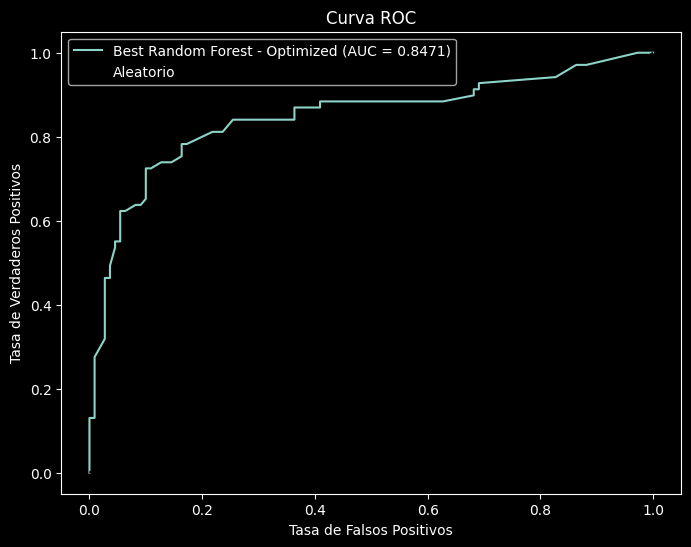


----- Best Random Forest - Optimized -----
Accuracy: 0.8427
Confusion Matrix:
[[414  25]
 [ 87 186]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       439
           1       0.88      0.68      0.77       273

    accuracy                           0.84       712
   macro avg       0.85      0.81      0.82       712
weighted avg       0.85      0.84      0.84       712



,Model,Accuracy_train,Accuracy,Precision_train,Precision,Recall_train,Recall,F1-Score_train,F1-Score,ROC-AUC
0,Logistic Regression,0.810393,0.798883,0.769531,0.770492,0.721612,0.681159,0.744802,0.723077,0.837088
1,Decision Tree,0.889045,0.798883,0.914530,0.789474,0.783883,0.652174,0.844181,0.714286,0.833465
2,Random Forest,0.889045,0.798883,0.897541,0.779661,0.802198,0.666667,0.847195,0.718750,0.838274
3,Linear SVM,0.789326,0.776536,0.743083,0.737705,0.688645,0.652174,0.714829,0.692308,0.806192
4,SVM,0.832865,0.832402,0.815574,0.819672,0.728938,0.724638,0.769826,0.769231,0.851713
5,Best Random Forest - Optimized,0.842697,0.815642,0.881517,0.875000,0.681319,0.608696,0.768595,0.717949,0.847101


In [16]:
df_met_bestrf= classification_metrics(y_test, y_pred_rf, "Best Random Forest - Optimized", model=best_rf, roc_bool=True)
df_met_bestrf_train= classification_metrics(y_train, best_rf.predict(X_train), "Best Random Forest - Optimized", model=best_rf, roc_bool=False)

# Renombrar columnas de df_met_model_train para concatenar
df_met_bestrf_train = df_met_bestrf_train.drop(columns=["ROC-AUC"])
df_met_bestrf_train.rename(columns={col: col + '_train' for col in df_met_bestrf_train.columns if col != 'Model'}, inplace=True)

# Juntar los dos dataframes en uno
df_met_bestrf = df_met_bestrf.merge(df_met_bestrf_train, left_on='Model', right_on='Model')

metrics_summary = pd.concat([metrics_summary, df_met_bestrf])
    
metrics_summary.reset_index(drop=True)

### SVM

In [17]:
# Definir el modelo SVM
svm = SVC(probability=True)

# Definir el grid de hiperparámetros con distribución aleatoria
param_dist = {
    'C': stats.expon(scale=100),  # Distribución exponencial para C
    'gamma': stats.expon(scale=0.1),  # Distribución exponencial para gamma
    'kernel': ['rbf', 'linear']
}

# Aplicar RandomizedSearchCV
start_time = time.time()  # Iniciar el temporizador
random_search = RandomizedSearchCV(svm, param_dist, n_iter=50, cv=5, scoring='accuracy', verbose=3, random_state=42)

# Entrenar el RandomizedSearchCV
random_search.fit(X_train, y_train)

# Detener el temporizador y calcular el tiempo transcurrido
end_time = time.time()
elapsed_time = end_time - start_time
print(f"El tiempo total de ejecución fue: {elapsed_time:.2f} segundos")

# Mostrar los mejores parámetros
print("Mejores parámetros:", random_search.best_params_)

# Evaluar el mejor modelo
best_svm = random_search.best_estimator_
y_pred = best_svm.predict(X_test)

# Mostrar la precisión del mejor modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del mejor SVM en el conjunto de prueba: {accuracy:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END C=46.92680899768591, gamma=0.3010121430917521, kernel=rbf;, score=0.818 total time=   0.1s
[CV 2/5] END C=46.92680899768591, gamma=0.3010121430917521, kernel=rbf;, score=0.804 total time=   0.0s
[CV 3/5] END C=46.92680899768591, gamma=0.3010121430917521, kernel=rbf;, score=0.796 total time=   0.0s
[CV 4/5] END C=46.92680899768591, gamma=0.3010121430917521, kernel=rbf;, score=0.831 total time=   0.0s
[CV 5/5] END C=46.92680899768591, gamma=0.3010121430917521, kernel=rbf;, score=0.796 total time=   0.0s
[CV 1/5] END C=151.27241738646856, gamma=0.09084469696321254, kernel=linear;, score=0.790 total time=   0.2s
[CV 2/5] END C=151.27241738646856, gamma=0.09084469696321254, kernel=linear;, score=0.762 total time=   0.3s
[CV 3/5] END C=151.27241738646856, gamma=0.09084469696321254, kernel=linear;, score=0.796 total time=   0.2s
[CV 4/5] END C=151.27241738646856, gamma=0.09084469696321254, kernel=linear;, score=0.810 t

In [18]:
# Definir el modelo SVM
svm = SVC(probability=True)

# Definir el grid de hiperparámetros que queremos probar
param_grid = {
    'C': [10, 20, 40, 50, 55, 60, 65, 66, 67, 68, 69, 70, 100],  # Parámetro de regularización
    'gamma': [0.1, 0.08, 0.06, 0.05, 0.03, 0.01],  # Coeficiente del kernel RBF
    'kernel': ['rbf']  # Tipos de kernel a probar
}

# Aplicar GridSearchCV para encontrar los mejores hiperparámetros
start_time = time.time()  # Iniciar el temporizador
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', verbose=3)

# Entrenar el GridSearch con los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Detener el temporizador y calcular el tiempo transcurrido
end_time = time.time()
elapsed_time = end_time - start_time
print(f"El tiempo total de ejecución fue: {elapsed_time:.2f} segundos")

Fitting 5 folds for each of 78 candidates, totalling 390 fits
[CV 1/5] END .......C=10, gamma=0.1, kernel=rbf;, score=0.832 total time=   0.0s
[CV 2/5] END .......C=10, gamma=0.1, kernel=rbf;, score=0.783 total time=   0.0s
[CV 3/5] END .......C=10, gamma=0.1, kernel=rbf;, score=0.824 total time=   0.0s
[CV 4/5] END .......C=10, gamma=0.1, kernel=rbf;, score=0.831 total time=   0.0s
[CV 5/5] END .......C=10, gamma=0.1, kernel=rbf;, score=0.824 total time=   0.0s
[CV 1/5] END ......C=10, gamma=0.08, kernel=rbf;, score=0.832 total time=   0.0s
[CV 2/5] END ......C=10, gamma=0.08, kernel=rbf;, score=0.783 total time=   0.0s
[CV 3/5] END ......C=10, gamma=0.08, kernel=rbf;, score=0.817 total time=   0.0s
[CV 4/5] END ......C=10, gamma=0.08, kernel=rbf;, score=0.831 total time=   0.0s
[CV 5/5] END ......C=10, gamma=0.08, kernel=rbf;, score=0.824 total time=   0.0s
[CV 1/5] END ......C=10, gamma=0.06, kernel=rbf;, score=0.818 total time=   0.0s
[CV 2/5] END ......C=10, gamma=0.06, kernel=rbf

In [19]:
# Mostrar los mejores parámetros encontrados
print("Mejores parámetros:", grid_search.best_params_)

# Evaluar el mejor modelo en el conjunto de prueba
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test)

# Mostrar la precisión del mejor modelo en el conjunto de prueba
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del mejor SVM en el conjunto de prueba: {accuracy:.4f}")

# Mostrar el informe de clasificación
print("Informe de clasificación:")
print(classification_report(y_test, y_pred))


Mejores parámetros: {'C': 55, 'gamma': 0.1, 'kernel': 'rbf'}
Precisión del mejor SVM en el conjunto de prueba: 0.7989
Informe de clasificación:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       110
           1       0.76      0.70      0.73        69

    accuracy                           0.80       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.80      0.80      0.80       179




----- Best SVM - Optimized -----
Accuracy: 0.7989
Confusion Matrix:
[[95 15]
 [21 48]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       110
           1       0.76      0.70      0.73        69

    accuracy                           0.80       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.80      0.80      0.80       179

ROC-AUC: 0.8454


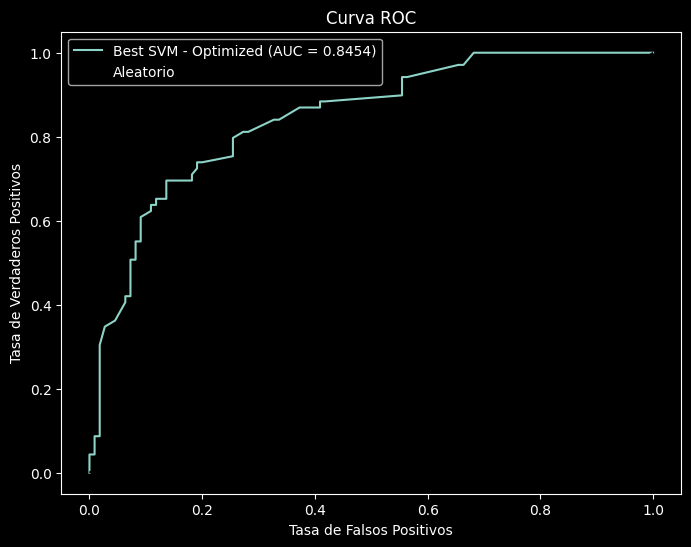


----- Best SVM - Optimized -----
Accuracy: 0.8750
Confusion Matrix:
[[407  32]
 [ 57 216]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       439
           1       0.87      0.79      0.83       273

    accuracy                           0.88       712
   macro avg       0.87      0.86      0.87       712
weighted avg       0.87      0.88      0.87       712



,Model,Accuracy_train,Accuracy,Precision_train,Precision,Recall_train,Recall,F1-Score_train,F1-Score,ROC-AUC
0,Logistic Regression,0.810393,0.798883,0.769531,0.770492,0.721612,0.681159,0.744802,0.723077,0.837088
1,Decision Tree,0.889045,0.798883,0.914530,0.789474,0.783883,0.652174,0.844181,0.714286,0.833465
2,Random Forest,0.889045,0.798883,0.897541,0.779661,0.802198,0.666667,0.847195,0.718750,0.838274
3,Linear SVM,0.789326,0.776536,0.743083,0.737705,0.688645,0.652174,0.714829,0.692308,0.806192
4,SVM,0.832865,0.832402,0.815574,0.819672,0.728938,0.724638,0.769826,0.769231,0.851713
5,Best Random Forest - Optimized,0.842697,0.815642,0.881517,0.875000,0.681319,0.608696,0.768595,0.717949,0.847101
6,Best SVM - Optimized,0.875000,0.798883,0.870968,0.761905,0.791209,0.695652,0.829175,0.727273,0.845389


In [20]:
df_met_bestsvm= classification_metrics(y_test, y_pred, "Best SVM - Optimized", model=best_svm, roc_bool=True)
df_met_bestsvm_train= classification_metrics(y_train, best_svm.predict(X_train), "Best SVM - Optimized", model=best_svm, roc_bool=False)

# Renombrar columnas de df_met_model_train para concatenar
df_met_bestsvm_train = df_met_bestsvm_train.drop(columns=["ROC-AUC"])
df_met_bestsvm_train.rename(columns={col: col + '_train' for col in df_met_bestsvm_train.columns if col != 'Model'}, inplace=True)

# Juntar los dos dataframes en uno
df_met_bestsvm = df_met_bestsvm.merge(df_met_bestsvm_train, left_on='Model', right_on='Model')

metrics_summary = pd.concat([metrics_summary, df_met_bestsvm])
    
metrics_summary.reset_index(drop=True)

## Adicional: entrenamiento de red neuronal

Fitting 3 folds for each of 10 candidates, totalling 30 fits


2025-03-07 19:00:39.941676: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-03-07 19:00:39.945982: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-07 19:00:39.946009: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-03-07 19:00:39.946274: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-07 19:00:39.946294: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-03-07 19:00:40.277883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[CV 1/3] END activation=relu, batch_size=32, dropout_rate=0.4, epochs=100, neurons=64, optimizer=rmsprop;, score=0.790 total time=   3.8s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[CV 2/3] END activation=relu, batch_size=32, dropout_rate=0.4, epochs=100, neurons=64, optimizer=rmsprop;, score=0.793 total time=   3.7s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[CV 3/3] END activation=relu, batch_size=32, dropout_rate=0.4, epochs=100, neurons=64, optimizer=rmsprop;, score=0.747 total time=   4.9s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
[CV 1/3] END activation=tanh, batch_size=32, dropout_rate=0.4, epochs=100, neurons=16, optimizer=adam;, score=0.790 total time=   9.0s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
[CV 2/3] END activation=tanh, batch_size=32, dropout_rate=0.4, epochs=100, neurons=16, optimizer=adam;, score=0.772 total time=   7.4s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[CV 3/3] END activation=tanh, batch_size=32, dropout_rate=0.4, epochs=100, neurons=16, o

2025-03-07 19:03:26.751579: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-03-07 19:03:26.751607: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-03-07 19:03:26.751612: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-07 19:03:26.751619: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-03-07 19:03:26.751629: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-07 19:03:26.751634: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-07 19:03:26.751635: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-03-07 19:03:26.751644: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/t

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5

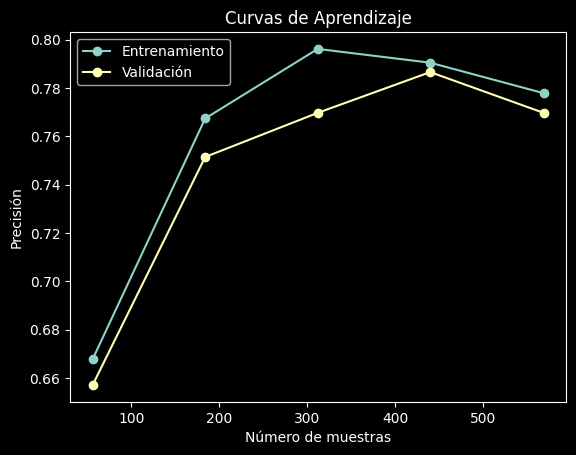

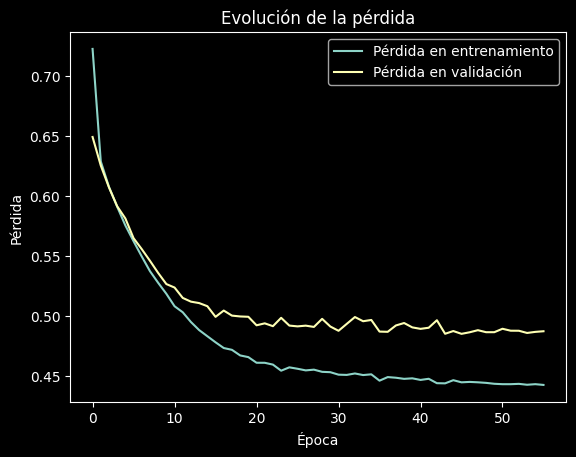

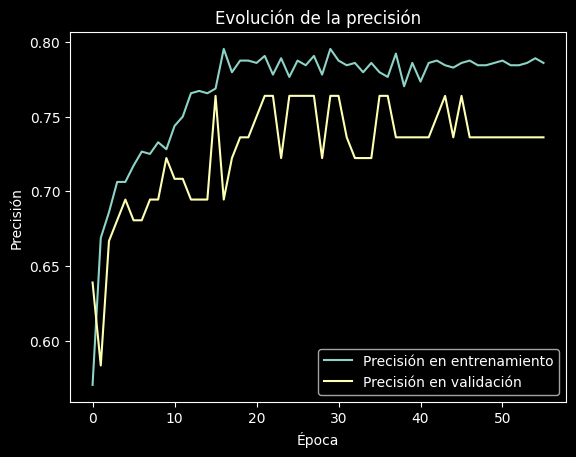

In [ ]:

# Función para crear el modelo
def create_model(input_dim, optimizer='adam', activation='relu', neurons=32, dropout_rate=0.2):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(input_dim,)))
    model.add(tf.keras.layers.Dense(neurons, activation=activation))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(neurons, activation=activation))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Creación del envoltorio personalizado para KerasClassifier
class MyKerasClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, optimizer='adam', activation='relu', neurons=32, dropout_rate=0.2,
                 batch_size=32, epochs=100, verbose=0):
        self.optimizer = optimizer
        self.activation = activation
        self.neurons = neurons
        self.dropout_rate = dropout_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.verbose = verbose
        self.model_ = None

    def fit(self, X, y):
        # Se determina el número de características a partir de X
        input_dim = X.shape[1]
        
        # Se crea el modelo
        self.model_ = create_model(input_dim,
                                   optimizer=self.optimizer,
                                   activation=self.activation,
                                   neurons=self.neurons,
                                   dropout_rate=self.dropout_rate)
        
        # Definir callbacks para early stopping y reducción de la tasa de aprendizaje
        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
        
        # Entrenar el modelo utilizando un validation_split y los callbacks
        self.history_ = self.model_.fit(X, y,
                                        batch_size=self.batch_size,
                                        epochs=self.epochs,
                                        verbose=self.verbose,
                                        validation_split=0.1,
                                        callbacks=[early_stop, lr_scheduler])
        return self

    def predict(self, X):
        # Se realiza la predicción y se aplica un umbral de 0.5 para clasificación binaria
        preds = self.model_.predict(X)
        return (preds > 0.5).astype(int).ravel()

    def get_params(self, deep=True):
        # Devuelve los hiperparámetros para la búsqueda en grid
        return {"optimizer": self.optimizer,
                "activation": self.activation,
                "neurons": self.neurons,
                "dropout_rate": self.dropout_rate,
                "batch_size": self.batch_size,
                "epochs": self.epochs,
                "verbose": self.verbose}

    def set_params(self, **parameters):
        # Actualiza los parámetros
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

# --- Configuración de la búsqueda de hiperparámetros ---

# Definir el grid de hiperparámetros
param_dist = {
    'optimizer': ['adam', 'rmsprop'],
    'activation': ['relu', 'tanh'],
    'neurons': [16, 32, 64, 128],
    'dropout_rate': [0.0, 0.2, 0.4],
    'batch_size': [32, 64],
    'epochs': [50, 100]
}

# Instanciar el clasificador personalizado
model = MyKerasClassifier(verbose=0)

# Configurar RandomizedSearchCV para la búsqueda de hiperparámetros
random_search = RandomizedSearchCV(estimator=model,
                                   param_distributions=param_dist,
                                   n_iter=10,
                                   cv=3,
                                   verbose=3,
                                   random_state=42,
                                   scoring="accuracy")

# Supongamos que X_train, y_train, X_test, y_test ya están definidos
random_search.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros:", random_search.best_params_)

# Evaluar el mejor modelo en los datos de prueba
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del mejor modelo en los datos de prueba: {accuracy:.4f}")
print("Informe de clasificación:")
print(classification_report(y_test, y_pred))

# --- Curvas de Aprendizaje usando la función learning_curve ---
train_sizes, train_scores, valid_scores = learning_curve(best_model,
                                                         X_train, y_train,
                                                         cv=5,
                                                         scoring='accuracy',
                                                         n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', label='Entrenamiento')
plt.plot(train_sizes, valid_scores_mean, 'o-', label='Validación')
plt.xlabel('Número de muestras')
plt.ylabel('Precisión')
plt.title('Curvas de Aprendizaje')
plt.legend(loc='best')
plt.show()

# --- Evolución de la pérdida y precisión durante el entrenamiento ---
history = best_model.history_.history

plt.figure()
plt.plot(history['loss'], label='Pérdida en entrenamiento')
plt.plot(history['val_loss'], label='Pérdida en validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Evolución de la pérdida')
plt.legend()
plt.show()

plt.figure()
plt.plot(history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history['val_accuracy'], label='Precisión en validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Evolución de la precisión')
plt.legend()
plt.show()


In [22]:
df_met_bestnn = classification_metrics(y_test, y_pred, "Red Neuronal - Optimized", model=best_model, roc_bool=True)
df_met_bestnn_train = classification_metrics(y_train, best_model.predict(X_train), "Red Neuronal - Optimized", model=best_model, roc_bool=True)

# Renombrar columnas de df_met_model_train para concatenar
df_met_bestnn_train = df_met_bestnn_train.drop(columns=["ROC-AUC"])
df_met_bestnn_train.rename(columns={col: col + '_train' for col in df_met_bestnn_train.columns if col != 'Model'}, inplace=True)

# Juntar los dos dataframes en uno
df_met_bestnn = df_met_bestnn.merge(df_met_bestnn_train, left_on='Model', right_on='Model')

metrics_summary = pd.concat([metrics_summary, df_met_bestnn])
    
metrics_summary.reset_index(drop=True)


----- Red Neuronal - Optimized -----
Accuracy: 0.7877
Confusion Matrix:
[[96 14]
 [24 45]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       110
           1       0.76      0.65      0.70        69

    accuracy                           0.79       179
   macro avg       0.78      0.76      0.77       179
weighted avg       0.79      0.79      0.78       179

ROC-AUC: No disponible para Red Neuronal - Optimized
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

----- Red Neuronal - Optimized -----
Accuracy: 0.7907
Confusion Matrix:
[[377  62]
 [ 87 186]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       439
           1       0.75      0.68      0.71       273

    accuracy                           0.79       712
   macro avg       0.78      0.77      0.77       712
weighted avg       0.79      0.79      0.79       712

ROC-AUC: No disponi

,Model,Accuracy_train,Accuracy,Precision_train,Precision,Recall_train,Recall,F1-Score_train,F1-Score,ROC-AUC
0,Logistic Regression,0.810393,0.798883,0.769531,0.770492,0.721612,0.681159,0.744802,0.723077,0.837088
1,Decision Tree,0.889045,0.798883,0.914530,0.789474,0.783883,0.652174,0.844181,0.714286,0.833465
2,Random Forest,0.889045,0.798883,0.897541,0.779661,0.802198,0.666667,0.847195,0.718750,0.838274
3,Linear SVM,0.789326,0.776536,0.743083,0.737705,0.688645,0.652174,0.714829,0.692308,0.806192
4,SVM,0.832865,0.832402,0.815574,0.819672,0.728938,0.724638,0.769826,0.769231,0.851713
5,Best Random Forest - Optimized,0.842697,0.815642,0.881517,0.875000,0.681319,0.608696,0.768595,0.717949,0.847101
6,Best SVM - Optimized,0.875000,0.798883,0.870968,0.761905,0.791209,0.695652,0.829175,0.727273,0.845389
7,Red Neuronal - Optimized,0.790730,0.787709,0.750000,0.762712,0.681319,0.652174,0.714012,0.703125,NaN


## Exportar modelos

In [23]:
# Exportar mejor Random Forest
filename = '03_Models/random_forest.pkl'
pickle.dump(best_rf, open(filename, 'wb'))

In [24]:
# Exportar mejor SVM
filename = '03_Models/svm.pkl'
pickle.dump(best_svm, open(filename, 'wb'))

In [25]:
# Exportar Red Neuronal
filename = '03_Models/red_neuronal.pkl'
pickle.dump(best_model, open(filename, 'wb'))

## Submission

In [26]:
df_test= pd.read_csv("./00_Data/Cleaned/test_clean.csv")
print("Test dimensions:", df_train.shape)
df_test

Test dimensions: (891, 9)


,Pclass,Has_Cabin,Sex_male,Embarked_Q,Embarked_S,Age_bin,FamilySize,Fare_Range
0,3,0,1,1,0,2,1,0
1,3,0,0,0,1,2,2,0
2,2,0,1,1,0,3,1,1
3,3,0,1,0,1,2,1,1
4,3,0,0,0,1,2,3,1
...,...,...,...,...,...,...,...,...
413,3,0,1,0,1,2,1,1
414,1,1,0,0,0,2,1,3
415,3,0,1,0,1,2,1,0
416,3,0,1,0,1,2,1,1


### Random Forest 

In [27]:
y_test = best_rf.predict(df_test)

df_sub = pd.DataFrame({
    'PassengerId': np.arange(892, 892 + len(y_test)),
    'Survived': y_test
})

df_sub.to_csv('submission_randomforest.csv', index=False)

In [32]:
!kaggle competitions submit -c titanic -f submission_randomforest.csv -m "Random Forest submission"

100%|██████████████████████████████████████| 2.77k/2.77k [00:00<00:00, 6.33kB/s]
Successfully submitted to Titanic - Machine Learning from Disaster

### SVM

In [33]:
y_test = best_svm.predict(df_test)

df_sub = pd.DataFrame({
    'PassengerId': np.arange(892, 892 + len(y_test)),
    'Survived': y_test
})

df_sub.to_csv('submission_svm.csv', index=False)

In [34]:
!kaggle competitions submit -c titanic -f submission_svm.csv -m "SVM submission"

100%|██████████████████████████████████████| 2.77k/2.77k [00:00<00:00, 5.58kB/s]
Successfully submitted to Titanic - Machine Learning from Disaster

### Red Neuronal

In [35]:
y_test = best_model.predict(df_test)

df_sub = pd.DataFrame({
    'PassengerId': np.arange(892, 892 + len(y_test)),
    'Survived': y_test
})

df_sub.to_csv('submission_redneuronal.csv', index=False)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [36]:
!kaggle competitions submit -c titanic -f submission_redneuronal.csv -m "Neural Network submission"

100%|██████████████████████████████████████| 2.77k/2.77k [00:00<00:00, 6.15kB/s]
Successfully submitted to Titanic - Machine Learning from Disaster

![Resultado de la entrega](Kaggle_submission.png)